# We are applying Transfer Learning here since computational power is very limited
### Approach will be to train only the feature extractor while freezing all other model weights

In [75]:
### Import required libraries
import numpy as np
import pandas as pd

### This gives error - FIX IT!
# from openslide import open_slide
# from openslide.deepzoom import DeepZoomGenerator

from PIL import Image
import cv2
from skimage.transform import resize
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score, auc, PrecisionRecallDisplay
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import tifffile as tiff   # we want to write/handle our images as "TIFF"
import random
import glob
import os
from pathlib import Path
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchinfo import summary
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from torchvision import models
import requests
import gradcam
from gradcam import GradCAM
from gradcam.utils import visualize_cam

import warnings
# warnings.filterwarnings(action='ignore', category=TqdmWarning)

In [61]:
### Specify all the various "PATHS" to be used

model_name = 'ViT_b_16'
model_train_info = 'Level_L_Nclasstrain_5000_N_batch_64_N_epochs_30'
test_patient_id_1, test_patient_id_2, test_patient_id_3, test_patient_id_4, test_patient_id_5  = 'P1', 'P2', 'P3', 'P4', 'P5'

### MAIN FOLDERS
# Folder containing all ".svs" files
path_svs = '/mnt/hd1/ani/Liver_pathology_project/Raw_data/'

# Path of "Datasets" folder
path_datasets = '/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/'

# Path of "Results" folder
path_results = '/mnt/hd1/ani/Liver_pathology_project/Results/'

# Path of "saved models"
path_saved_models = '/mnt/hd1/ani/Liver_pathology_project/Saved_models/'

# Which SD dataset
path_sd = 'sd_30/'

### SPECIFIC FOLDERS
# Folder containing image tiles of all levels extracted from the ".svs" files
path_wsi_imgs = path_datasets + 'Patient_image_sets_sd_30/'

# Folder containing image tiles for training & validation of DL Network
# Inside this folder, we need to have the class (NASH and ACR) folders otherwise it won't work 
path_model_train_val_dataset = path_datasets + 'Training_validation_sd_30/' + 'Dataset_train_val_level_L_balancedclasses_Nclass_5000/'


# Path of Confusion Matrix figure file
filepath_save_CM_P1 = path_results + 'DL_results/' + path_sd + model_name + '_' + model_train_info +'_' + test_patient_id_1 + '.png'
filepath_save_CM_P2 = path_results + 'DL_results/' + path_sd + model_name + '_' + model_train_info + '_' + test_patient_id_2 + '.png'
filepath_save_CM_P3 = path_results + 'DL_results/' + path_sd + model_name + '_' + model_train_info + '_' + test_patient_id_3 + '.png'
filepath_save_CM_P4 = path_results + 'DL_results/' + path_sd + model_name + '_' + model_train_info + '_' + test_patient_id_4 + '.png'
filepath_save_CM_P5 = path_results + 'DL_results/' + path_sd + model_name + '_' + model_train_info + '_' + test_patient_id_5 + '.png'


# Path of file where model state (weights & biases) are stored
filepath_save_model_state = path_saved_models + path_sd + model_name + '_' + model_train_info + '.pth'

# Path of "Training progress"
path_train_progress = '/mnt/hd1/ani/Liver_pathology_project/Training_progress/' + path_sd + model_name + '_' + model_train_info + '.png'

# Parent path of "Test" dataset - this should contain a folder called "Test_set" otherwise it won't work
path_test_imgs_parent = path_datasets + 'Testing_sd_30/'

# Path of folder containing all the images for "Testing"
# for testing, we will use images from 3 patient WSIs chosen randomly
filename_test_set_P1 = 'Test_set_NASH_id_645_ACR_id_468'
filename_test_set_P2 = 'Test_set_NASH_id_156_ACR_id_262'
filename_test_set_P3 = 'Test_set_NASH_id_190_ACR_id_271_1'
filename_test_set_P4 = 'Test_set_NASH_id_139_1_ACR_id_823'
filename_test_set_P5 = 'Test_set_NASH_id_105_ACR_id_504'

# Make sure classes are balanced
# path_test_imgs_P1 = path_test_imgs_parent + filename_test_set_P1 + '/' + 'NASH/'
# path_test_imgs_P2 = path_test_imgs_parent + filename_test_set_P2 + '/' + 'NASH/'
# path_test_imgs_P3 = path_test_imgs_parent + filename_test_set_P3 + '/' + 'NASH/'
# path_test_imgs_P4 = path_test_imgs_parent + filename_test_set_P4 + '/' + 'NASH/'
# path_test_imgs_P5 = path_test_imgs_parent + filename_test_set_P5 + '/' + 'NASH/'

In [265]:
# ### Prepare images for Deep Learning 
# ### Save image tiles at all levels for all patient WSIs
# # We also want to sort the images into "Strong_signal" and "Weak_signal"

# # Folder where all WSI ".svs" files exist
# dir_svs = path_svs

# # Folder where we want to save all image tiles
# dir_imgs = path_wsi_imgs

# # Get list of all patient WSIs
# dir_name = dir_svs
# wsi_img_list=(glob.glob(dir_name + "*.svs"))
# # wsi_img_list

# # # Check resolution
# # slide = open_slide(wsi_img_list[19])
# # slide_props = slide.properties
# # print('Pixel size of X in um is: ', slide_props['openslide.mpp-x'])
# # print('Pixel size of Y in um is: ', slide_props['openslide.mpp-y'])

# # Change path to wherever you want to store all the image tiles
# os.chdir(dir_imgs)
# for i in range(len(wsi_img_list)): 
    
#     # # if we want to test for 1 WSI case 
#     # if i == 3:
#     #     break
    
#     # Get WSI filename w/o extension - we will use this to name folders
#     filename_noext = os.path.splitext(os.path.basename(wsi_img_list[i]))[0]
    
#     # Create unique folder for patient
#     parent_dir = dir_imgs
#     directory = filename_noext
#     path = os.path.join(parent_dir, directory)
    
#     # check if directory exists already - if so don't create new directory
#     if os.path.exists(path) == False:
        
#         print(f'Saving WSI: {filename_noext} for quantitative analysis ...')
#         os.mkdir(path)
    
#         # Create sub-folders for different tile levels
#         # Read WSI image
#         slide = open_slide(wsi_img_list[i])
    
#         tile_sz = 256
#         tiles = DeepZoomGenerator(slide, tile_size=tile_sz, overlap=0, limit_bounds=False)
#         num_levels = tiles.level_count
        
#         # Create folder for each tile level
#         for j in range(num_levels-1, num_levels):  # All levels will generate too may images
#             cols, rows = tiles.level_tiles[j]
#             # First, create unique folder for each tile level
#             path_level = os.path.join(path, '%d' % j)
#             os.mkdir(path_level)
            
#             # create sub-folders for segregating tile images
#             parent_dir_level = path_level
#             directory_level_1, directory_level_2 = 'High_signal', 'Low_signal'
#             path_level_seg_1 = os.path.join(parent_dir_level, directory_level_1)
#             path_level_seg_2 = os.path.join(parent_dir_level, directory_level_2)
#             os.mkdir(path_level_seg_1)
#             os.mkdir(path_level_seg_2)
            
#             # Saving image tiles at each level
#             for row in range(rows):
#                 for col in range(cols):
#                     tile_name = os.path.join(path_level, '%s_%d_%d' % (filename_noext, col, row))
#                     temp_tile = tiles.get_tile(j, (col, row))
#                     temp_tile_np = np.array(temp_tile.convert('RGB'))
#                     # plt.imsave(tile_name + ".png", temp_tile_np)
                    
# #                     image = tiff.imread(tile_name)
#                     # use SD to filter
#                     if (temp_tile_np.std() >= 30):
#                         tile_name_1 = os.path.join(path_level_seg_1, '%s_%d_%d' % (filename_noext, col, row))
#                         plt.imsave(tile_name_1 + ".png", temp_tile_np)
#                     else:
#                         pass
#                         # tile_name_2 = os.path.join(path_level_seg_2, '%s_%d_%d' % (filename_noext, col, row))
#                         # plt.imsave(tile_name_2 + ".png", temp_tile_np)
#         print(f'WSI: {filename_noext} imageset created !')
#     else:
#         print('Folder already exists !!')

In [62]:
# Device + Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"

img_size = 224
patch_size = 16
num_channels = 3
batch_size = 32
epochs = 10
class_names = {1: 'NASH', 0: 'ACR'}

print(device)

# Check GPU properties
for i in range(torch.cuda.device_count()): 
    print(torch.cuda.get_device_properties(i))
    
    # Get memory
    print('Total memory in GB: ', torch.cuda.get_device_properties(i).total_memory/(1.024*1e9))
    print('Memory reserved in GB: ', torch.cuda.memory_reserved(i)/(1.024*1e9))
    print('Memory allocated in GB: ', torch.cuda.memory_allocated(i)/(1.024*1e9))

cuda
_CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24251MB, multi_processor_count=64)
Total memory in GB:  24.83328
Memory reserved in GB:  16.244736
Memory allocated in GB:  1.379001


In [72]:
### In this cell, we want to set up the code in such a way that multiple models can be selected without having 
### to change all the code everytime

# Only change these few lines
model_weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=model_weights).to(device)

# Freeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = False
    
# Change the classifier head (set the seeds to ensure same initialization with linear head)
torch.manual_seed(0)
# dict_emb = model.encoder.state_dict()   # this is only for ViT models
# in_features = dict_emb['pos_embedding'].shape[-1]
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(class_names)).to(device) # this will work for any ViT but for other models, change in_features as appropriate
# model # uncomment for model output

# Get automatic transforms from pretrained ViT weights
model_transforms = model_weights.transforms()
print(model_transforms)

# Print model summary
summary(model=model, 
        input_size=(batch_size, num_channels, img_size, img_size), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=12,
        row_settings=["var_names"]
)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [49]:
# Dataset with transforms applied
# Verify path - make sure it is correct!
dataset = ImageFolder(path_model_train_val_dataset, transform=model_transforms)

# Split dataset into "training" and "validation"
def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, random_state=0)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

datasets_spl = train_val_dataset(dataset)

dataloaders_pretrained = {x:DataLoader(datasets_spl[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train','val']}
images, labels = next(iter(dataloaders_pretrained['train']))
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [50]:
### Define training loop
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
      # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model, 
                                        dataloader=test_dataloader, 
                                        loss_fn=loss_fn, 
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {test_loss:.4f} | "
          f"val_acc: {test_acc:.4f}"
      )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(test_loss)
        results["val_acc"].append(test_acc)
                             
    # Return the filled results at the end of the epochs
    return results

In [51]:
### Train feature extractor ViT model

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
torch.manual_seed(0)
model_results = train(model=model, 
                      train_dataloader=dataloaders_pretrained['train'], 
                      test_dataloader=dataloaders_pretrained['val'], 
                      optimizer=optimizer, 
                      loss_fn=loss_fn, 
                      epochs=epochs, 
                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6142 | train_acc: 0.6550 | val_loss: 0.5490 | val_acc: 0.7271
Epoch: 2 | train_loss: 0.4458 | train_acc: 0.8178 | val_loss: 0.4607 | val_acc: 0.7896
Epoch: 3 | train_loss: 0.3795 | train_acc: 0.8468 | val_loss: 0.4146 | val_acc: 0.8010
Epoch: 4 | train_loss: 0.3382 | train_acc: 0.8701 | val_loss: 0.3860 | val_acc: 0.8187
Epoch: 5 | train_loss: 0.3129 | train_acc: 0.8902 | val_loss: 0.3765 | val_acc: 0.8281
Epoch: 6 | train_loss: 0.2897 | train_acc: 0.8967 | val_loss: 0.3605 | val_acc: 0.8271
Epoch: 7 | train_loss: 0.2694 | train_acc: 0.9058 | val_loss: 0.3484 | val_acc: 0.8573
Epoch: 8 | train_loss: 0.2480 | train_acc: 0.9142 | val_loss: 0.3401 | val_acc: 0.8469
Epoch: 9 | train_loss: 0.2354 | train_acc: 0.9113 | val_loss: 0.3246 | val_acc: 0.8792
Epoch: 10 | train_loss: 0.2255 | train_acc: 0.9231 | val_loss: 0.3148 | val_acc: 0.8562
Epoch: 11 | train_loss: 0.2173 | train_acc: 0.9359 | val_loss: 0.3460 | val_acc: 0.8406
Epoch: 12 | train_loss: 0.2066 | train_ac

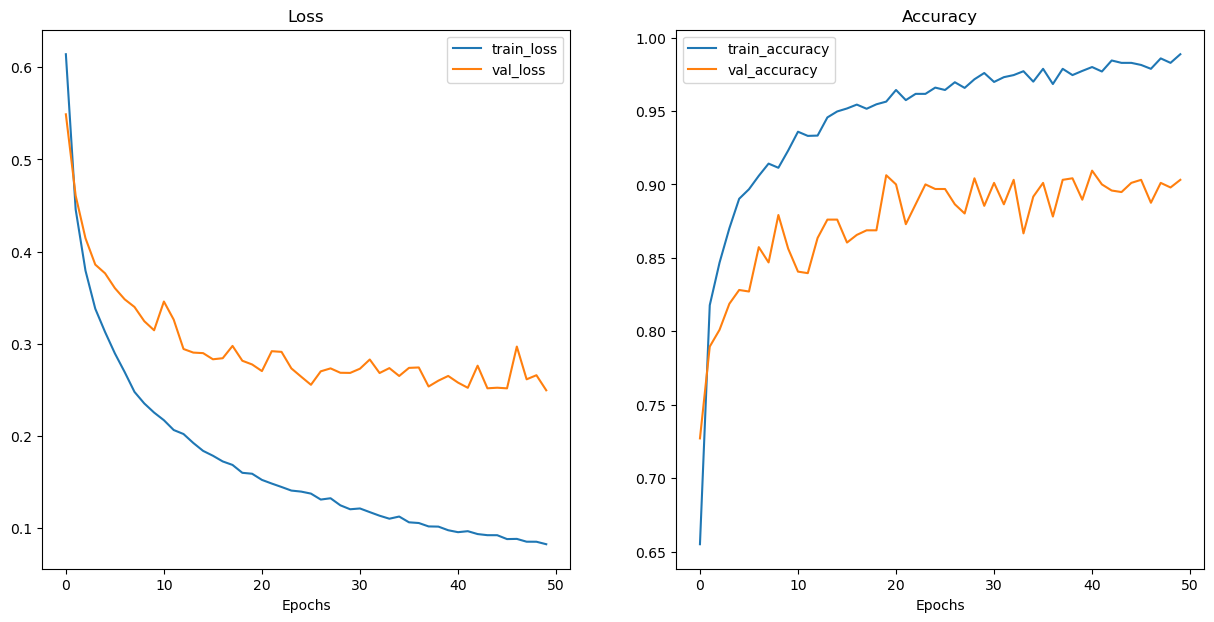

In [52]:
### Plot loss curves
def plot_loss_curves(results, path):
    loss = results["train_loss"]
    test_loss = results["val_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Saving plots
    plt.savefig(path)
    
plot_loss_curves(model_results, path_train_progress)

In [53]:
### Save model
torch.save(model.state_dict(), filepath_save_model_state)

# Check model size
# Get the model size in bytes then convert to megabytes
model_size = Path(filepath_save_model_state).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained Pretrained_ViT_b_16 feature extractor model size: {model_size} MB")

Pretrained Pretrained_ViT_b_16 feature extractor model size: 327 MB


In [63]:
### Loading saved model 
# Here we need to initialize the model and then load the saved model checkpoint (".pth" file)

# Get pretrained weights
loaded_model_wts = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available
# loaded_model_wts = torchvision.models.ResNet50_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# Setup model instance with pretrained weights
loaded_model = torchvision.models.vit_b_16().to(device)
# loaded_model = torchvision.models.resnet50().to(device)

# # Freeze the base parameters
# for parameter in loaded_model.parameters():
#     parameter.requires_grad = False
    
# Change the classifier head (set the seeds to ensure same initialization with linear head)
torch.manual_seed(0)

dict_emb = loaded_model.encoder.state_dict()   # this is only for ViT models
in_features = dict_emb['pos_embedding'].shape[-1]

loaded_model.heads = nn.Linear(in_features=in_features, out_features=len(class_names)).to(device)
# loaded_model # uncomment for model output

loaded_model.load_state_dict(torch.load(filepath_save_model_state, map_location=torch.device('cpu')))

<All keys matched successfully>

Total memory in GB:  24.83328
Memory reserved in GB:  3.237888
Memory allocated in GB:  0.3434775
Total memory in GB:  24.83328
Memory reserved in GB:  12.320768
Memory allocated in GB:  0.3434775


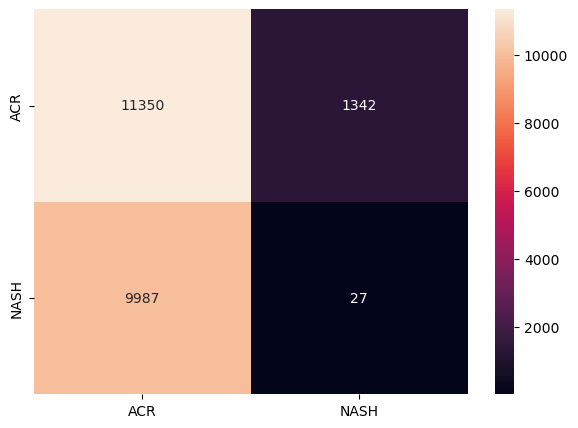

In [68]:
### Plot Confusion Matrix on a "Test" set

import gc
torch.cuda.empty_cache()
gc.collect()

# Check GPU memory usage at the beginning
for i in range(torch.cuda.device_count()):     
    print('Total memory in GB: ', torch.cuda.get_device_properties(i).total_memory/(1.024*1e9))
    print('Memory reserved in GB: ', torch.cuda.memory_reserved(i)/(1.024*1e9))
    print('Memory allocated in GB: ', torch.cuda.memory_allocated(i)/(1.024*1e9))

# Its better to create a "Dataloader" to process a batch rather than iterate through individual examples
data_dir = path_test_imgs_parent
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), 
                                 transform=loaded_model_wts.transforms())
                  for x in [filename_test_set_P5]}

# To generate the "Test" Dataloader, lets first get the path where all the test images are stored
# Size of the Dataloader will be set to the no. of test images
# dir_test_imgs = path_test_imgs_P1
# test_imgs_list=(glob.glob(dir_test_imgs + "*.png"))
dataloaders = {x: DataLoader(image_datasets[x], batch_size=1024, 
                             shuffle=False, num_workers=0)
              for x in [filename_test_set_P5]}


def conf_mat(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval() 
    
    y_pred, y_true = [], []
    
    # Turn on inference context manager
    with torch.inference_mode():
      # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Get model predictions
            test_pred_labels = test_pred_logits.argmax(dim=1)
            
            y_true.extend(y.data.cpu().numpy())
            y_pred.extend(test_pred_labels.data.cpu().numpy())

    return y_true, y_pred

# constant for classes
classes = ('ACR', 'NASH')

y_true, y_pred = conf_mat(model=loaded_model, dataloader=dataloaders[filename_test_set_P5], device=device)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
#                      columns = [i for i in classes])
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7, 5))
sn.heatmap(df_cm, annot=True, fmt=".0f");
plt.savefig(filepath_save_CM_P5)

# Check GPU memory usage at the end
for i in range(torch.cuda.device_count()):     
    print('Total memory in GB: ', torch.cuda.get_device_properties(i).total_memory/(1.024*1e9))
    print('Memory reserved in GB: ', torch.cuda.memory_reserved(i)/(1.024*1e9))
    print('Memory allocated in GB: ', torch.cuda.memory_allocated(i)/(1.024*1e9))

In [73]:
### Testing Model on some different unseen examples

import gc
torch.cuda.empty_cache()
gc.collect()

# # Check GPU memory usage at the beginning
# for i in range(torch.cuda.device_count()):     
#     print('Total memory in GB: ', torch.cuda.get_device_properties(i).total_memory/(1.024*1e9))
#     print('Memory reserved in GB: ', torch.cuda.memory_reserved(i)/(1.024*1e9))
#     print('Memory allocated in GB: ', torch.cuda.memory_allocated(i)/(1.024*1e9))

data_dir = path_test_imgs_parent
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), 
                                 transform=loaded_model_wts.transforms())
                  for x in [filename_test_set_P5]}

# To generate the "Test" Dataloader, lets first get the path where all the test images are stored
# Size of the Dataloader will be set to the no. of test images
# dir_test_imgs = path_test_imgs_P3
# test_imgs_list=(glob.glob(dir_test_imgs + "*.png"))
dataloaders = {x: DataLoader(image_datasets[x], batch_size=1024, 
                             shuffle=False, num_workers=0)
              for x in [filename_test_set_P5]}

# Applying trained model on test images and computing Accuracy
def model_test(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval() 

    # Setup test accuracy value
    test_acc, test_f1 = 0, 0
    y_pred, y_true = [], []
    
    # Turn on inference context manager
    with torch.inference_mode():
      # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            
            y_true.extend(y.data.cpu().numpy())
            y_pred.extend(test_pred_labels.data.cpu().numpy())
            
    test_acc = balanced_accuracy_score(y_true, y_pred)
    test_f1 = f1_score(np.array(y_true), np.array(y_pred), average='weighted')
    return test_acc, test_f1


test_acc, f1 = model_test(model=loaded_model, dataloader=dataloaders[filename_test_set_P5], device=device)
print('Accuracy of test set images: ', test_acc)
print('F1-score of test set images: ', f1)

# # Check GPU memory usage at the end
# for i in range(torch.cuda.device_count()):     
#     print('Total memory in GB: ', torch.cuda.get_device_properties(i).total_memory/(1.024*1e9))
#     print('Memory reserved in GB: ', torch.cuda.memory_reserved(i)/(1.024*1e9))
#     print('Memory allocated in GB: ', torch.cuda.memory_allocated(i)/(1.024*1e9))

Accuracy of test set images:  0.44848016432840226
F1-score of test set images:  0.3749696369110591


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


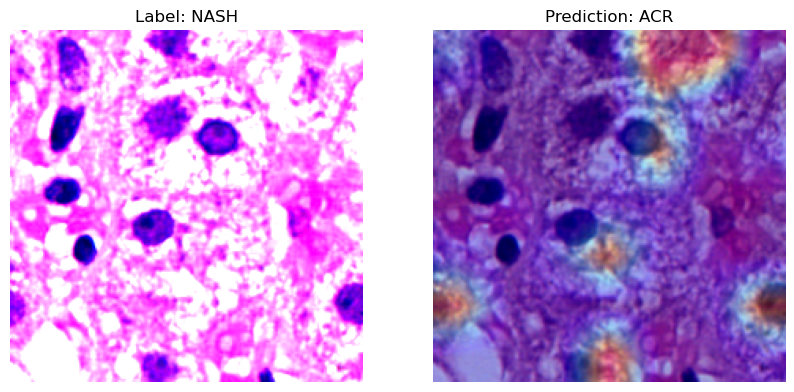

In [9]:
### Grad-CAM

# Get Test dataLoader
data_dir = path_test_imgs_parent
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), 
                                 transform=loaded_model_wts.transforms())
                  for x in [filename_test_set_P1]}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=1, 
                             shuffle=True, num_workers=0)
              for x in [filename_test_set_P1]}

img, label = next(iter(dataloaders[filename_test_set_P1]))

loaded_model = torchvision.models.resnet50().to(device)
loaded_model.fc = nn.Linear(in_features=loaded_model.fc.in_features, out_features=len(class_names)).to(device)
loaded_model.load_state_dict(torch.load(filepath_save_model_state, map_location=torch.device('cpu')))
model = loaded_model

# Get model prediction on this image
pred = model(img).argmax(dim=1)

model.eval()
gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')
mask, logit = gradcam(img, class_idx=label.numpy())
heatmap, cam_result = visualize_cam(mask, img, alpha=1.0)

#Plotting
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(img[0,:,:,:].permute(1,2,0));
axs[0].title.set_text('Label: ' + class_names[int(label.numpy())]);
axs[0].axis('off');

axs[1].imshow(cam_result.permute(1,2,0));
axs[1].title.set_text('Prediction: ' + class_names[int(pred.numpy())]);
axs[1].axis('off');

# Saving
# plt.savefig(path_results + 'DL results/sd_30/' + 'GradCAM_' + 'Tar_' + class_names[int(label.numpy())] + '_' + 'Pred_' + class_names[int(pred.numpy())])